<a href="https://colab.research.google.com/github/Lamino1788/TCC_TFT/blob/main/Backtesting/Notebooks/Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
!pip install pytorch-forecasting
!pip install pytorch-lightning
!pip install yfinance
!pip install empyrical

In [85]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
import torch
from torchmetrics import Metric

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, QuantileLoss, MAPE
import yfinance as yf
import pandas as pd
import pytorch_lightning as pl
import numpy as np


from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, RMSE


import warnings
from sklearn.exceptions import DataConversionWarning

from pytorch_lightning.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

warnings.filterwarnings(action='ignore', category=UserWarning)


import logging
import datetime
import empyrical as ep
torch.backends.cudnn.enabled = False
pd.options.mode.chained_assignment = None

In [87]:
max_encoder_length = 126
max_prediction_length = 10

In [88]:
class SMAE(Metric):
    global max_prediction_length
    def __init__(self):
        super().__init__(dist_sync_on_step=False)
        self.add_state("loss", default=torch.tensor(0.0), dist_reduce_fx="sum")

    def update(self, preds, target):
        preds = preds.view(int(len(preds)/max_prediction_length),max_prediction_length)
        preds = preds.sum(dim=1)
        target = target.view(int(len(target)/max_prediction_length),max_prediction_length)
        target = target.sum(dim=1)

        smae = (abs(preds - target).mean())**2

        self.loss +=  smae

    def compute(self):
        return self.loss

In [89]:
def add_macd(df, short_period=12, long_period=26, signal_period=9): #Moving Average Convergence Divergence
    exp1 = df['Close'].ewm(span=short_period, adjust=False).mean()
    exp2 = df['Close'].ewm(span=long_period, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    df['MACD'] = macd
    df['MACD_Signal'] = signal
    return df

def add_rsi(df, period=30): # Relative Strength Index
    delta = df['Close'].diff()
    delta = delta[1:]
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    for period in [7, 14, 22, 30, 60]:
      average_gain = up.rolling(window=period).mean()
      average_loss = abs(down.rolling(window=period).mean())
      rs = average_gain / average_loss
      rsi = 100.0 - (100.0 / (1.0 + rs))

      df[f'RSI_{period}'] = rsi
    return df

def encode_cyclical(df, col, max_val):
    df[col] = np.cos(2 * np.pi * df[col]/max_val)
    return df

In [90]:
def make_Complete_Data(Ticker):
  global unknown_reals
  Ticker_data = yf.Ticker(Ticker)

  Complete_Data = Ticker_data.history(start = datetime.datetime(2000,1,1), end = datetime.datetime(2023,12,18))
  Complete_Data.index = pd.to_datetime(Complete_Data.index, format='%y-%m-%d').strftime('%Y-%m-%d')
  Complete_Data = Complete_Data[['Close']]

  tickers=[
      "EUR=X", "JPY=X", "GBP=X", 'BRL=X', "MXN=X", "CAD=X"
  ]

  for ticker in tickers:
    data = yf.Ticker(ticker)
    hist = data.history(start = datetime.datetime(2000,1,1), end = datetime.datetime(2023,12,18))
    hist.index = pd.to_datetime(hist.index, format='%y-%m-%d').strftime('%Y-%m-%d')
    Complete_Data = Complete_Data.join(pd.DataFrame(hist['Close']), rsuffix=f'_{ticker}')

  Complete_Data = np.log(Complete_Data / Complete_Data.shift(1))
  Complete_Data['Close_prediction'] = Complete_Data['Close'].shift(max_prediction_length).fillna(0)
  Complete_Data['Close_encoder'] = Complete_Data['Close'].shift(max_encoder_length).fillna(0)
  Complete_Data = Complete_Data.fillna(0).drop(list(Complete_Data.index)[0])

  Complete_Data.reset_index(inplace=True)
  Complete_Data.rename(columns={'date': 'Date'},inplace=True)

  for i in Complete_Data.index:
    Complete_Data.loc[i,'Rolling_Avg_22d'] = Complete_Data.loc[i-30:i-1, 'Close'].mean()
    Complete_Data.loc[i,'Rolling_Vol_22d'] = Complete_Data.loc[i-30:i-1, 'Close'].std()

  Complete_Data['Exponential_Avg'] = Complete_Data.Close.ewm(span=max_encoder_length).mean()
  Complete_Data = add_macd(Complete_Data)
  Complete_Data = add_rsi(Complete_Data)

  Complete_Data.fillna(0)
  Complete_Data.loc[Complete_Data.Rolling_Avg_22d == 0, 'Rolling_Avg_22d'] = Complete_Data.loc[Complete_Data.Rolling_Avg_22d == 0, 'Close']

  unknown_reals = list(Complete_Data.columns)[1:]

  Complete_Data['Ticker'] = Ticker

  Complete_Data.index = Complete_Data.index.astype(int)
  Complete_Data['Time_Fix'] = Complete_Data.index

  Complete_Data['Year'] = Complete_Data.Date.str.split('-').str[0].astype(int)
  Complete_Data['Month'] = Complete_Data.Date.str.split('-').str[1].astype(int)
  Complete_Data['Day'] = Complete_Data.Date.str.split('-').str[2].astype(int)

  Complete_Data = encode_cyclical(Complete_Data, 'Month', 12)
  Complete_Data = encode_cyclical(Complete_Data, 'Day', 31)

  return Complete_Data


In [91]:
Ticker = "MXN=X"
Complete_Data = make_Complete_Data(Ticker)
Complete_Data.dropna(inplace=True)

In [92]:
Complete_Data

,Date,Close,Close_EUR=X,Close_JPY=X,Close_GBP=X,Close_BRL=X,Close_MXN=X,Close_CAD=X,Close_prediction,Close_encoder,...,RSI_7,RSI_14,RSI_22,RSI_30,RSI_60,Ticker,Time_Fix,Year,Month,Day
60,2004-02-24,0.003529,-0.008395,-0.000924,-0.011500,0.000000,0.003529,-0.004880,-0.001981,0.000000,...,55.030436,49.118318,57.800188,50.241209,51.347492,MXN=X,60,2004,5.000000e-01,0.151428
61,2004-02-25,-0.003076,0.014374,0.007091,0.009406,-0.006106,-0.003076,0.005255,-0.012793,0.000000,...,48.662406,46.912298,47.232361,49.712047,50.128047,MXN=X,61,2004,5.000000e-01,0.347305
62,2004-02-26,0.000091,0.003929,0.004669,0.004819,-0.003067,0.000091,0.005898,-0.001005,0.000000,...,53.009766,51.793650,49.143426,50.323935,50.717495,MXN=X,62,2004,5.000000e-01,0.528964
63,2004-02-27,0.000453,-0.003691,-0.002103,-0.003322,-0.008569,0.000453,-0.006572,-0.000914,0.000000,...,40.880497,51.518198,48.037915,49.763217,49.950530,MXN=X,63,2004,5.000000e-01,0.688967
64,2004-03-01,-0.007636,0.003691,-0.003117,0.000860,-0.004139,-0.007636,0.001722,-0.001740,0.000000,...,44.176961,46.676794,43.663271,48.793483,48.885605,MXN=X,64,2004,6.123234e-17,0.979530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,2023-12-11,-0.007177,0.002447,0.004875,0.002766,-0.003430,-0.007177,-0.001310,-0.004236,-0.000060,...,41.804599,49.712019,47.652668,48.999185,49.668379,MXN=X,5216,2023,1.000000e+00,-0.612106
5217,2023-12-12,0.001314,-0.000075,0.007572,0.000013,0.008833,0.001314,-0.000206,0.002611,-0.003478,...,48.068252,48.841377,46.848318,50.798896,49.756163,MXN=X,5217,2023,1.000000e+00,-0.758758
5218,2023-12-13,-0.003815,-0.002976,-0.005526,-0.001281,0.005616,-0.003815,0.000515,-0.002194,0.000357,...,53.721668,48.548386,50.925634,49.339540,49.930273,MXN=X,5218,2023,1.000000e+00,-0.874347
5219,2023-12-14,-0.002401,-0.008067,-0.017407,-0.004144,-0.009329,-0.002401,-0.005677,0.009406,0.007623,...,37.302661,49.338031,50.201907,52.509899,49.641195,MXN=X,5219,2023,1.000000e+00,-0.954139


In [105]:
validation = Complete_Data.loc[(Complete_Data.Year < 2023) & (Complete_Data.Year > 2016)].reset_index(drop=True)
test = Complete_Data.loc[(Complete_Data.Year > 2022)].reset_index(drop=True)
test = pd.concat([validation.iloc[-(max_encoder_length+max_prediction_length):], test], axis=0, ignore_index=True).reset_index(drop=True)
base = Complete_Data.loc[Complete_Data.Year < 2016].reset_index(drop=True)


In [108]:
training = TimeSeriesDataSet(
    base,
    time_idx="Time_Fix",
    target="Close",
    group_ids=["Ticker"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Ticker"],
    time_varying_known_reals=['Month', 'Day'],
    time_varying_unknown_reals=unknown_reals,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    min_encoder_length=max_encoder_length // 2,
    allow_missing_timesteps=True
)

val = TimeSeriesDataSet(
    validation,
    time_idx="Time_Fix",
    target="Close",
    group_ids=["Ticker"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Ticker"],
    time_varying_known_reals=['Month', 'Day'],
    time_varying_unknown_reals=unknown_reals,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    min_encoder_length=max_encoder_length // 2,
    allow_missing_timesteps=True
)

test_set = TimeSeriesDataSet(
    test,
    time_idx="Time_Fix",
    target="Close",
    group_ids=["Ticker"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Ticker"],
    time_varying_known_reals=['Month', 'Day'],
    time_varying_unknown_reals=unknown_reals,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    min_encoder_length=max_encoder_length // 2,
    allow_missing_timesteps=True

)

In [109]:
batch_size = 16
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = val.to_dataloader(train=False, batch_size=batch_size*10, num_workers=0)
test_dataloader = test_set.to_dataloader(train=False, batch_size=batch_size*10, num_workers=0)

In [110]:
import pickle
import optuna
from optuna.pruners import MedianPruner
from pytorch_lightning.callbacks import EarlyStopping
import lightning.pytorch as pl

pruner = MedianPruner(n_startup_trials=1, n_warmup_steps=5, interval_steps=1)
storage = 'sqlite:////content/drive/MyDrive/All_Round_Study.db'
study = optuna.create_study(pruner=pruner, storage=storage, direction="minimize", study_name='Currencies_Study', load_if_exists=True)

[I 2023-12-18 18:35:02,613] Using an existing study with name 'Currencies_Study' instead of creating a new one.


In [111]:
best_params = study.best_trial.params
best_params


{'gradient_clip_val': 0.021007981936097743,
 'hidden_size': 167,
 'dropout': 0.31205391907053703,
 'hidden_continuous_size': 155,
 'attention_head_size': 4,
 'learning_rate': 0.0006025595860743578}

In [112]:
best_tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=best_params['learning_rate'],
        hidden_size=best_params['hidden_size'],
        attention_head_size=4,
        dropout=best_params['dropout'],
        hidden_continuous_size=best_params['hidden_continuous_size'],
        output_size=1,
        loss=SMAE(),
        log_interval=10,
        reduce_on_plateau_patience=4,
        lstm_layers=2,
        log_val_interval=10,
    )

In [113]:
def make_predictions(test_data: pd.DataFrame, best_tft, max_encoder_length, max_prediction_length):
    j = 0
    test_data = test_data.sort_values(["Date", "Ticker"])
    output = {}
    for ticker_out in test_data.Ticker.unique():
      aux_df = test_data.loc[test_data.Ticker == ticker_out]
      indices = aux_df.iloc[max_encoder_length+max_prediction_length:].Time_Fix
      for i in indices:
        rolling_df = aux_df.loc[aux_df.Time_Fix.isin(list(range(i-max_encoder_length-max_prediction_length, i)))]
        if j == max_prediction_length:
            j = 0
        if j == 0:
            test_predictions = best_tft.predict(rolling_df, mode="raw", return_x=True)
            counter = 0
            for ticker in rolling_df.Ticker.unique():
                if ticker == ticker_out:
                    pred = test_predictions.output.prediction[counter].cpu().numpy().cumsum()[-1]
                    if ticker not in output.keys():
                        output[ticker] = [pred]
                        output[ticker + "_Real"] = [rolling_df["Close_" + ticker].iloc[-max_prediction_length]]
                        output[ticker + "_Date"] = [rolling_df.loc[rolling_df.Ticker == ticker].Date.iloc[-max_prediction_length]]
                    else:
                        output[ticker] = output[ticker] + [pred]
                        output[ticker + "_Real"] = output[ticker + "_Real"] + [rolling_df["Close_" + ticker].iloc[-max_prediction_length]]
                        output[ticker + "_Date"] = output[ticker + "_Date"] + [rolling_df.loc[rolling_df.Ticker == ticker].Date.iloc[-max_prediction_length]]
                    counter = counter + 1
            j += 1
        else:
            rolling_df = test_data.loc[test_data.Time_Fix.isin(list(range(i-max_encoder_length-max_prediction_length, i)))]
            counter = 0
            for ticker in rolling_df.Ticker.unique():
                if ticker == ticker_out:
                    if ticker in output.keys():
                        output[ticker + "_Real"] = output[ticker + "_Real"] + [rolling_df["Close_" + ticker].iloc[-max_prediction_length]]
                        output[ticker + "_Date"] = output[ticker + "_Date"] + [rolling_df.loc[rolling_df.Ticker == ticker].Date.iloc[-max_prediction_length]]
                        output[ticker] = output[ticker] + [output[ticker][-1]]
                counter = counter + 1
                j += 1
    return output


Dos modelos treinados, pegamos o melhor. No caso a seed 3 teve a melhor performance no período de validação

In [114]:
best = [13]
results_test = {}
for i in best:
    path_to_model = f"/content/drive/MyDrive/TCC/Best_Models/{Ticker}/{Ticker}/Seeds/{i}.pth"
    print(path_to_model)

    best_tft.load_state_dict(torch.load(path_to_model, map_location=torch.device('cpu')))
    pred = make_predictions(test, best_tft, max_encoder_length, max_prediction_length)
    results_test[i] = pred


/content/drive/MyDrive/TCC/Best_Models/MXN=X/MXN=X/Seeds/13.pth


In [115]:
aux = {}
aux[f"{Ticker}"] = results_test[best[0]][f"{Ticker}"]
aux[f"{Ticker}_Real"] = results_test[best[0]][f"{Ticker}_Real"]
aux[f"{Ticker}_Date"] = results_test[best[0]][f"{Ticker}_Date"]
test_output = pd.DataFrame(aux).set_index(f"{Ticker}_Date")
test_output[f"{Ticker}"] = test_output[f"{Ticker}"]*0

for k in best:
    test_output[f"{Ticker}"] = test_output[f"{Ticker}"] + results_test[k][f"{Ticker}"]
test_output[f'{Ticker}'] = test_output[f'{Ticker}']/len(best)

test_output[f"{Ticker}_Real"] = np.exp(test_output[f"{Ticker}_Real"])-1
test_output[f"{Ticker}"] = np.exp(test_output[f"{Ticker}"])-1

win_rate_list = np.sign(test_output[f"{Ticker}"]) == np.sign(test_output[f"{Ticker}_Real"])

test_output["Returns"] = np.sign(test_output[f"{Ticker}"]) * test_output[f"{Ticker}_Real"]
test_output.index.rename('date', inplace=True)
test_output.index = pd.to_datetime(test_output.index)
signs = np.sign(test_output[f"{Ticker}"])

test_output.rename(columns={f'{Ticker}_Real':f'{Ticker} Long Only', 'Returns': f"{Ticker} Using TFT"}, inplace=True)
test_output.drop(f"{Ticker}", axis=1, inplace=True)

In [144]:
def get_metrics(session_returns,benchmark_returns, omega):
    strategy = pd.concat([session_returns, benchmark_returns], axis=1,keys=["Strategy", "Benchmark"])

    bench_metrics = {
        'total_return': ep.cum_returns_final(strategy["Benchmark"]),
        'sharpe_ratio': ep.sharpe_ratio(strategy["Benchmark"]),
        'sortino_ratio': ep.sortino_ratio(strategy["Benchmark"]),
        'omega_ratio': ep.omega_ratio(strategy["Benchmark"]),
        'calmar_ratio': ep.calmar_ratio(strategy["Benchmark"]),
        'annual_volatility': ep.annual_volatility(strategy["Benchmark"]),
        'cvar': ep.conditional_value_at_risk(strategy["Benchmark"]),
        'downside_risk': ep.downside_risk(strategy["Benchmark"]),
        'max_dd': ep.max_drawdown(strategy["Benchmark"]),
        'cagr': ep.cagr(strategy["Benchmark"], annualization=1)
    }
    strategy_metrics = {
        'total_return': ep.cum_returns_final(strategy["Strategy"]),
        'information_ratio': ep.sharpe_ratio(strategy["Strategy"], risk_free=strategy["Benchmark"].mean(),period='daily'),
        'sortino_ratio': ep.sortino_ratio(strategy["Strategy"]),
        'omega_ratio': ep.omega_ratio(strategy["Strategy"], risk_free=strategy["Benchmark"].mean(), required_return=omega, annualization=1),
        'calmar_ratio': ep.calmar_ratio(strategy["Strategy"]),
        'annual_volatility': ep.annual_volatility(strategy["Strategy"]),
        'cvar': ep.conditional_value_at_risk(strategy["Strategy"]),
        'downside_risk': ep.downside_risk(strategy["Strategy"], required_return=0),
        'max_dd': ep.max_drawdown(strategy["Strategy"]),
        'skewness': strategy["Strategy"].skew(),
        'kurtosis': strategy["Strategy"].kurtosis(),
        'max_daily_return': strategy["Strategy"].max()*100,
        'min_daily_return': strategy["Strategy"].min()*100,
        'beta': ep.beta(strategy["Strategy"], strategy["Benchmark"]),
        'cagr': ep.cagr(strategy["Strategy"], annualization=1)
    }

    strategy_metrics['cagr'] = ((session_returns.add(1).cumprod().iloc[-1])**(1/(len(session_returns)/252))) - 1
    bench_metrics['cagr'] = ((benchmark_returns.add(1).cumprod().iloc[-1])**(1/(len(benchmark_returns)/252))) - 1

    strategy_metrics['cagr'] = (1+strategy_metrics['cagr'])/(1+bench_metrics['cagr']) -1

    strategy_metrics['above'] = (session_returns.add(1).cumprod().iloc[-1]) ** (252/len(session_returns)) - (benchmark_returns.add(1).cumprod().iloc[-1]) ** (252/len(benchmark_returns))

    strategy_metrics['more'] = (session_returns.add(1).cumprod().iloc[-1])/(benchmark_returns.add(1).cumprod().iloc[-1])

    return strategy_metrics, bench_metrics

In [145]:
TFT_strategy_metrics, TFT_bench_metrics = get_metrics(test_output[f"{Ticker} Using TFT"], test_output[f"{Ticker} Long Only"], 0)
Long_strategy_metrics, Long_bench_metrics = get_metrics(test_output[f"{Ticker} Long Only"], test_output[f"{Ticker} Long Only"], 0)


<Axes: xlabel='date'>

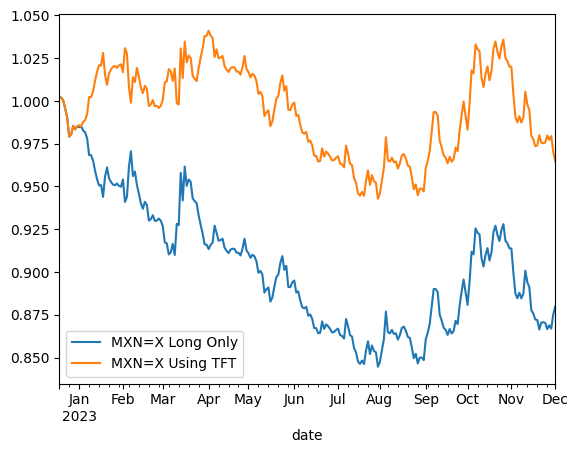

In [146]:
test_output.add(1).cumprod().plot()


In [147]:
pd.DataFrame(TFT_strategy_metrics, index=["TFT"])

,total_return,information_ratio,sortino_ratio,omega_ratio,calmar_ratio,annual_volatility,cvar,downside_risk,max_dd,skewness,kurtosis,max_daily_return,min_daily_return,beta,cagr,above,more
TFT,-0.03507,0.837383,-0.394139,1.156097,-0.374429,0.111144,-0.014841,0.075719,-0.094399,0.489127,2.267677,3.286836,-1.997071,0.567494,0.097533,0.085724,1.096722


In [148]:
pd.DataFrame(Long_strategy_metrics, index=["Long Only"])


,total_return,information_ratio,sortino_ratio,omega_ratio,calmar_ratio,annual_volatility,cvar,downside_risk,max_dd,skewness,kurtosis,max_daily_return,min_daily_return,beta,cagr,above,more
Long Only,-0.120169,6.938339e-16,-1.63695,1.0,-0.769194,0.110889,-0.013987,0.075087,-0.157399,0.844918,2.494309,3.286836,-1.683912,1.0,0.0,0.0,1.0


Para obter o resultado da carteira, roda-se todo o código acima para todos os ativos em uma dada classe. A partir disso, é feito uma média aritmética simples entre os resultados